## **Amazon Sentiment Analysis using Random forest, Logistic Regression and SVM** 

In [2]:
import re
import nltk
import pickle
import pandas as pd
import numpy as np
import requests
import joblib

In [3]:
# Data processing
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from yellowbrick.text import FreqDistVisualizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [4]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
from PIL import Image
from wordcloud import WordCloud,  ImageColorGenerator

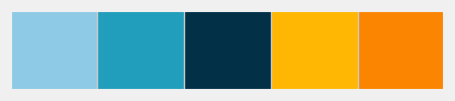

In [5]:
style.use("fivethirtyeight")
colors = ["#8ecae6", "#219ebc", "#023047", "#ffb703", "#fb8500"]
palette = sns.color_palette(colors)
sns.palplot(sns.color_palette(colors))
plt.show()
style.use("fivethirtyeight")

#### **Importing the Dataset:**

In [8]:
data = pd.read_csv("train.csv", header=None)
data.head(10)

,0,1,2
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...
5,5,There's a reason for the price,"There's a reason this CD is so expensive, even..."
6,1,Buyer beware,"This is a self-published book, and if you want..."
7,4,"Errors, but great story",I was a dissapointed to see errors on the back...
8,1,The Worst!,A complete waste of time. Typographical errors...
9,1,Oh please,I guess you have to be a romance novel lover f...


In [9]:
data.shape

(3000000, 3)

#### **Modifying the Dataset:**

Name the columns as "Rating", "Title" and "Review".

In [10]:
data.columns = ["Rating", "Title", "Review"]
data.head()

,Rating,Title,Review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


Combine the "Review" and "Title" column into one, as it should not contradict the overall sentiment.

In [11]:
data["Review"] = data["Title"] + " " + data["Review"]
data = data[['Review', 'Rating']]
data.head()

,Review,Rating
0,more like funchuck Gave this to my dad for a g...,3
1,Inspiring I hope a lot of people hear this cd....,5
2,The best soundtrack ever to anything. I'm read...,5
3,Chrono Cross OST The music of Yasunori Misuda ...,4
4,Too good to be true Probably the greatest soun...,5


The sentiment to each review is added by considering a rating above 3 as "Positive", below 3 as "Negative" and equal to 3 as "Neutral".

In [12]:
def sentiment(label):
    if label<3:
        return "Negative"
    elif label>3:
        return "Positive"
    else:
        return "Neutral"

In [13]:
data['Sentiment'] = data["Rating"].apply(sentiment)
data.head(10)

,Review,Rating,Sentiment
0,more like funchuck Gave this to my dad for a g...,3,Neutral
1,Inspiring I hope a lot of people hear this cd....,5,Positive
2,The best soundtrack ever to anything. I'm read...,5,Positive
3,Chrono Cross OST The music of Yasunori Misuda ...,4,Positive
4,Too good to be true Probably the greatest soun...,5,Positive
5,There's a reason for the price There's a reaso...,5,Positive
6,"Buyer beware This is a self-published book, an...",1,Negative
7,"Errors, but great story I was a dissapointed t...",4,Positive
8,The Worst! A complete waste of time. Typograph...,1,Negative
9,Oh please I guess you have to be a romance nov...,1,Negative


#### **Data Analysis:**

In [14]:
data.shape

(3000000, 3)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Review     object
 1   Rating     int64 
 2   Sentiment  object
dtypes: int64(1), object(2)
memory usage: 68.7+ MB


In [16]:
data.value_counts("Rating")

Rating
1    600000
2    600000
3    600000
4    600000
5    600000
Name: count, dtype: int64

In [17]:
data.value_counts("Sentiment")

Sentiment
Negative    1200000
Positive    1200000
Neutral      600000
Name: count, dtype: int64

C:\Users\Ajay\AppData\Local\Temp\ipykernel_7956\2359462227.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment", data=data,  palette=["#f8de7e","#32fa53",'#fa3232'])


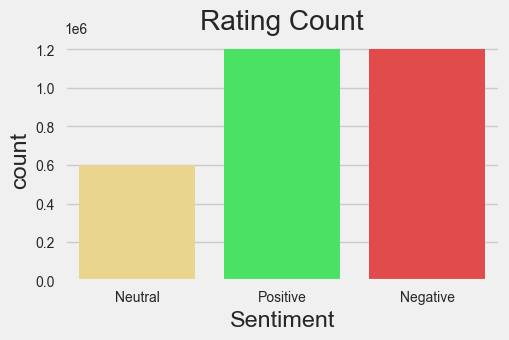

In [18]:
plt.figure(figsize=(5,3))
sns.countplot(x="Sentiment", data=data,  palette=["#f8de7e","#32fa53",'#fa3232'])
plt.title("Rating Count")
plt.show()

In [19]:
data["Rating"].value_counts()/len(data)

Rating
3    0.2
5    0.2
4    0.2
1    0.2
2    0.2
Name: count, dtype: float64

In [20]:
data["Sentiment"].value_counts()/len(data)

Sentiment
Positive    0.4
Negative    0.4
Neutral     0.2
Name: count, dtype: float64

In [21]:
data.isna().sum()

Review       188
Rating         0
Sentiment      0
dtype: int64

We can see that there are no null values in Ratings or Sentiments, so we do not have to drop any rows.
However, there are 188 rows that are empty, so we fill it with an empty string.

In [22]:
data = data.fillna(' ')
data.isna().sum()

Review       0
Rating       0
Sentiment    0
dtype: int64

**Number of characters present in each Review:**

Range the number of characters by 500 chars and so on.

In [23]:
text_len = data['Review'].groupby(pd.cut(data['Review'].str.len(),
                                          np.arange(0, 20000+500, 500))).count().rename_axis(['Range']).reset_index()
text_len.head()

C:\Users\Ajay\AppData\Local\Temp\ipykernel_7956\1459997233.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  text_len = data['Review'].groupby(pd.cut(data['Review'].str.len(),


,Range,Review
0,"(0, 500]",1911735
1,"(500, 1000]",1071380
2,"(1000, 1500]",16885
3,"(1500, 2000]",0
4,"(2000, 2500]",0


In [24]:
text_len_50 = text_len[text_len['Review'] > 50]
text_len_50

,Range,Review
0,"(0, 500]",1911735
1,"(500, 1000]",1071380
2,"(1000, 1500]",16885


C:\Users\Ajay\AppData\Local\Temp\ipykernel_7956\4000903183.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
C:\Users\Ajay\AppData\Local\Temp\ipykernel_7956\4000903183.py:2: UserWarning: 
The palette list has fewer values (5) than needed (40) and will cycle, which may produce an uninterpretable plot.
  g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
C:\Users\Ajay\AppData\Local\Temp\ipykernel_7956\4000903183.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


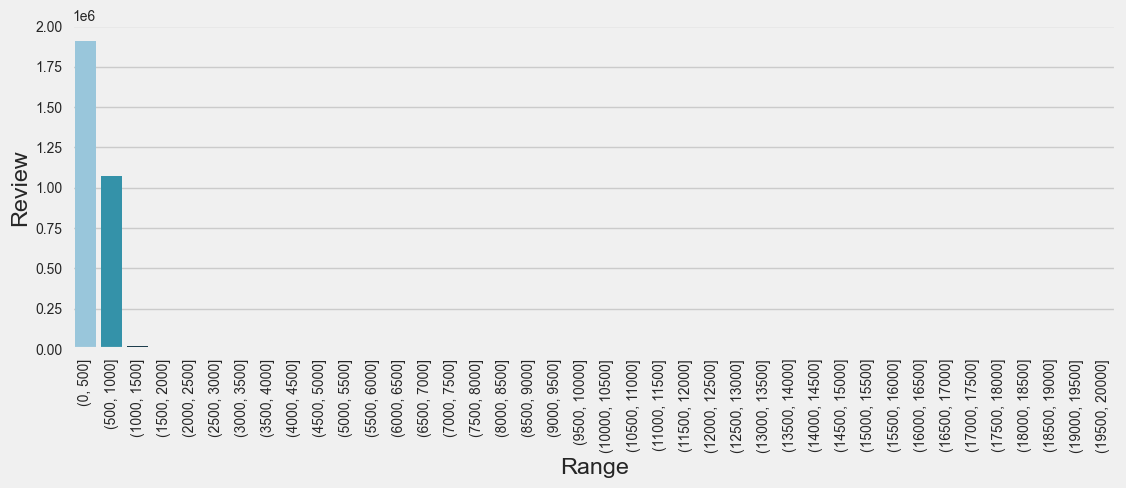

In [25]:
plt.figure(figsize=(12, 4))
g = sns.barplot( x=text_len_50['Range'][0:10], y=text_len_50['Review'][0:10], palette=palette)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

C:\Users\Ajay\AppData\Local\Temp\ipykernel_7956\1778809724.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x=data['Review'].str.len(), palette=palette)


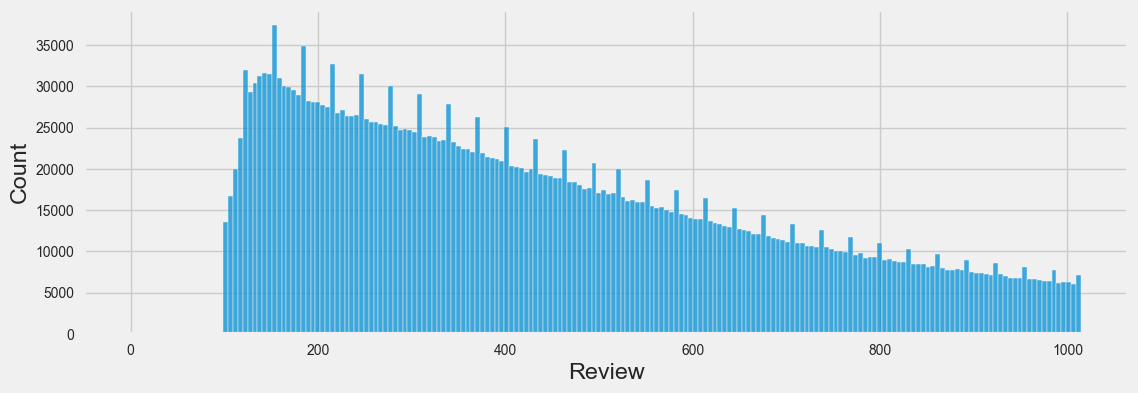

In [26]:
plt.figure(figsize=(12, 4))
sns.histplot(data=data, x=data['Review'].str.len(), palette=palette)
plt.show()

#### **Sampling the data:**
Since there are over 35 million reviews in this dataset, we will only use a portion of this for training our models. We will use Stratified Shuffle Split for this.

Benefits of StratifiedShuffleSplit:

- Maintains class balance: This is crucial for sentiment analysis where you have different classes representing positive, negative, and neutral reviews. Stratified sampling ensures the sampled data reflects the same proportion of each class as your original dataset, preventing biases in your model's training.
- Reduces computational cost: Training on a smaller sample is significantly faster and less resource-intensive compared to using the entire dataset.
- Provides representative data: Stratified sampling ensures the selected data is representative of the entire population, leading to a more robust and generalizable model.

In [27]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.97)
for train_index, test_index in split.split(data, data["Sentiment"]): 
    strat_data = data.reindex(train_index)

In [28]:
strat_data.head(10)

,Review,Rating,Sentiment
1089430,I've read better... ... and I've read worse. I...,3,Neutral
425024,"I guess I'm the only one, but..... Let me star...",2,Negative
1324813,DR. DRE HAS BEEN MADE EVEN BETTER ! The Chroni...,4,Positive
32725,Get entertained with Great Expectations Great ...,4,Positive
1179180,Teens Remember This book truly expresses the b...,5,Positive
2530356,Franco's heavy bag training I ordered this vid...,4,Positive
2128649,Magnolia I must concur with other reviewers - ...,4,Positive
883847,This is good for small babies. This is a very ...,3,Neutral
2479048,Useful but somewhat flawed. The list of Linux ...,3,Neutral
538502,garent earnings I thought the earnings were re...,4,Positive


We take a sample dataset of 75000 rows.

In [29]:
strat_data.shape

(90000, 3)

In [30]:
strat_data.value_counts("Sentiment")

Sentiment
Negative    36000
Positive    36000
Neutral     18000
Name: count, dtype: int64

#### **Cleaning data:**

Cleaning data includes

- Tokenization: Tokenization is the process of converting text into tokens before transforming it into vectors. 
- Stop Words Removal: Stop words are the most commonly occuring words which are not relevant in the context of the data and do not contribute any deeper meaning to the phrase. 
- Normalization: Words which look different due to casing or written another way but are the same in meaning need to be process correctly. Normalisation processes ensure that these words are treated equally. This includes:
    - Casing the characters: Converting character to the same case so the same words are recognised as the same. In this case we converted to lowercase
    - Negation Handling
- Lemmetization: This process finds the base or dictionary form of the word known as the lemma.

In [31]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ajay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
def preprocess_text(text):
    # Make text lowercase and remove links, text in square brackets, punctuation, and words containing numbers
    text = str(text)
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]|[^a-zA-Z\s]+|\w*\d\w*', ' ', text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words).strip()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lem_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(lem_tokens)

For example:

In [33]:
preprocess_text(data["Review"][2])

'best soundtrack ever anything reading lot review saying best game soundtrack figured write review disagree bit opinino yasunori mitsuda ultimate masterpiece music timeless listening year beauty simply refuse fade price tag pretty staggering must say going buy cd much money one feel would worth every penny'

In [34]:
preprocess_text(data["Review"][110])

'fabulous book completely instrumental guiding husband timberframing pursuit read much cover binding fallen broken hold best reference diyer look starting structure'

#### Did the same for all the reviews in the dataset.

In [35]:
strat_data["Review"] = strat_data["Review"].apply(preprocess_text)
strat_data.head(10)

,Review,Rating,Sentiment
1089430,read better read worse found interesting book ...,3,Neutral
425024,guess one let start saying huge dr seuss fan a...,2,Negative
1324813,dr dre made even better chronic dr dre first p...,4,Positive
32725,get entertained great expectation great expect...,4,Positive
1179180,teen remember book truly express belief real t...,5,Positive
2530356,franco heavy bag training ordered video aid tr...,4,Positive
2128649,magnolia must concur reviewer mann stuff rule ...,4,Positive
883847,good small baby cute bathrobe small baby soon ...,3,Neutral
2479048,useful somewhat flawed list linux command usef...,3,Neutral
538502,garent earnings thought earnings reasonably pr...,4,Positive


#### **Word Cloud:**

In [36]:
txt = "".join(strat_data["Review"].tolist())
len(txt)

24078973

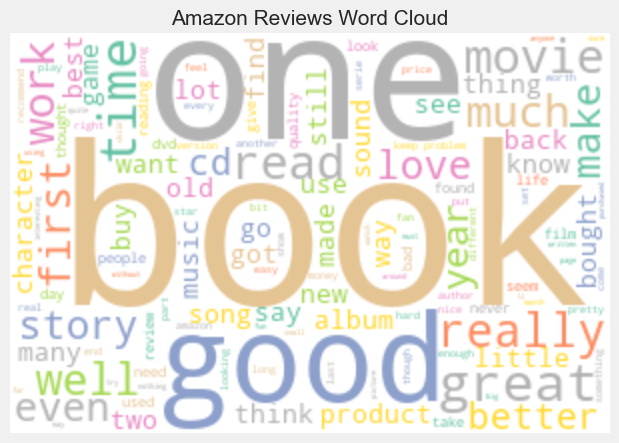

In [37]:
wc = WordCloud(width = 300, height = 200, random_state=1, background_color='white',
                colormap='Set2', collocations=False).generate(txt)

plt.figure(figsize=(6,6))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wc, interpolation='bilinear')
plt.title("Amazon Reviews Word Cloud", fontsize = 15)
plt.savefig('wordcloud.png')
plt.show()

#### **Vectorization:**

**Count Vectorization:**

Count vectoriser transforms a given text into a vector on the basis of the frequency of each word that occurs in the entire text. It is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors

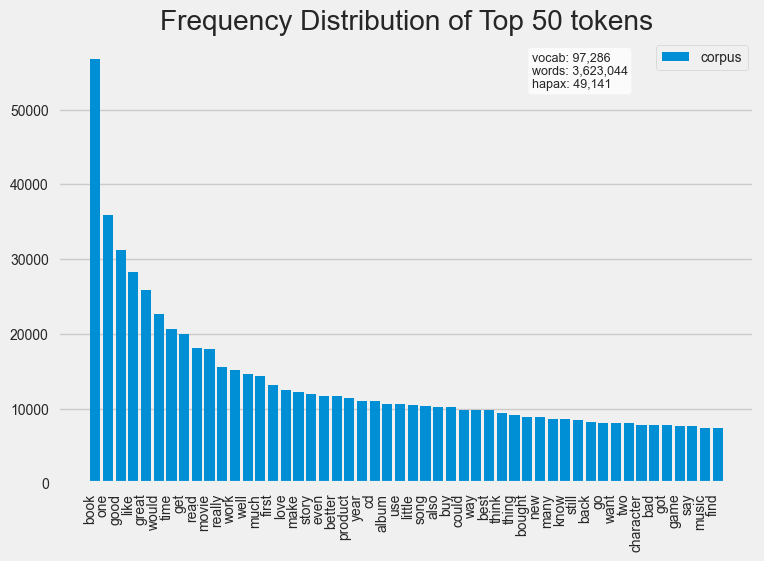

In [38]:
def word_distribution(text):
    vectorizer = CountVectorizer()
    docs = vectorizer.fit_transform(text)
    features = vectorizer.get_feature_names_out()
    
    # Freq Dist Visualizer
    visualizer = FreqDistVisualizer(features=features, orient='v')
    visualizer.fit(docs)
    visualizer.show()

word_distribution(strat_data['Review'])

**TF-IDF Vectorizer:**

Term frequency-inverse document frequency is a text vectorizer that transforms the text into a usable vector. It combines 2 concepts, Term Frequency (TF) and Document Frequency (DF).

- The term frequency is the number of occurrences of a specific term in a document. Term frequency indicates how important a specific term in a document. Term frequency represents every text from the data as a matrix whose rows are the number of documents and columns are the number of distinct terms throughout all documents.

- Document frequency is the number of documents containing a specific term. Document frequency indicates how common the term is.Inverse document frequency (IDF) is the weight of a term, it aims to reduce the weight of a term if the term’s occurrences are scattered throughout all the documents. 

In [39]:
tfidf_vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (1,3))
X_tfidf = tfidf_vectorizer.fit_transform(strat_data['Review'])
X_tfidf
X_tfidf.shape

(90000, 5000)

In [40]:
y = strat_data["Sentiment"]
y.shape

(90000,)

### **Training the model using Random forest**

In [41]:
from sklearn.ensemble import RandomForestClassifier

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state=42, test_size=0.20)

# Print shapes
print(X_train.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(y_train.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(X_test.shape)
print(f"Number of Test Samples: {X_test.shape[0]}")
print(y_test.shape)
print(f"Number of Test Samples: {y_test.shape[0]}")

(72000, 5000)
Number of Training Samples: 72000
(72000,)
Number of Training Samples: 72000
(18000, 5000)
Number of Test Samples: 18000
(18000,)
Number of Test Samples: 18000


In [ ]:

# Initialize and train Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:

# Predict using the trained model
predicted_rf = rf.predict(X_test)
np.mean(predicted_rf == y_test)

np.float64(0.6725)

#### **Model analysis**

In [ ]:

# Evaluate the model
print("Classification Report")
print(f"{classification_report(y_test, predicted_rf)}")
print(f"Accuracy: {accuracy_score(y_test, predicted_rf)}")


Classification Report
              precision    recall  f1-score   support

    Negative       0.67      0.81      0.74      7232
     Neutral       0.57      0.09      0.15      3597
    Positive       0.68      0.82      0.74      7171

    accuracy                           0.67     18000
   macro avg       0.64      0.57      0.54     18000
weighted avg       0.66      0.67      0.62     18000

Accuracy: 0.6725


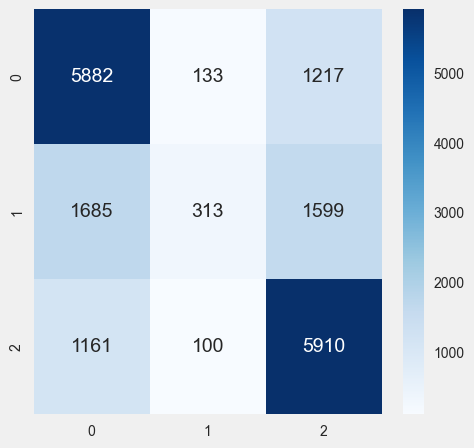

In [ ]:
# Confusion Matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, predicted_rf), annot=True, fmt="d", cmap='Blues')
plt.show()

In [ ]:
cm = confusion_matrix(y_test, predicted_rf)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[5882  133 1217]
 [1685  313 1599]
 [1161  100 5910]]

True Positives(TP) =  5882

True Negatives(TN) =  313

False Positives(FP) =  133

False Negatives(FN) =  1685


In [ ]:

TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]


In [ ]:
# Calculate additional metrics
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy of RF: {0:0.4f}'.format(classification_accuracy))

classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error of RF: {0:0.4f}'.format(classification_error))

precision = TP / float(TP + FP)
print('Precision of RF: {0:0.4f}'.format(precision))

recall = TP / float(TP + FN)
print('Recall or Sensitivity of RF: {0:0.4f}'.format(recall))

Classification accuracy of RF: 0.7731
Classification error of RF: 0.2269
Precision of RF: 0.9779
Recall or Sensitivity of RF: 0.7773


In [ ]:
# Predicted probabilities (for the first 10 samples)
y_pred_prob = rf.predict_proba(X_test)[0:10]
print(y_pred_prob)

[[0.61 0.09 0.3 ]
 [0.67 0.14 0.19]
 [0.5  0.13 0.37]
 [0.08 0.03 0.89]
 [0.32 0.31 0.37]
 [0.74 0.15 0.11]
 [0.23 0.27 0.5 ]
 [0.73 0.15 0.12]
 [0.23 0.15 0.62]
 [0.07 0.12 0.81]]


In [ ]:
# Create DataFrame for probabilities
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Prob of - Negative (0)',
                                         'Prob of - Neutral (1)', 'Prob of - Positive (2)'])
print(y_pred_prob_df)

   Prob of - Negative (0)  Prob of - Neutral (1)  Prob of - Positive (2)
0                    0.61                   0.09                    0.30
1                    0.67                   0.14                    0.19
2                    0.50                   0.13                    0.37
3                    0.08                   0.03                    0.89
4                    0.32                   0.31                    0.37
5                    0.74                   0.15                    0.11
6                    0.23                   0.27                    0.50
7                    0.73                   0.15                    0.12
8                    0.23                   0.15                    0.62
9                    0.07                   0.12                    0.81


In [ ]:
# Example to classify a custom input
inp_test = input("Enter review: ")
print(inp_test)

# Preprocess input
inp_test = preprocess_text(inp_test)
print("After preprocessing: ", inp_test)

# Convert input to TF-IDF features
inp_test = tfidf_vectorizer.transform([inp_test])

# Predict using Random Forest
rf.predict(inp_test)

Bad Quality product
After preprocessing:  bad quality product


array(['Negative'], dtype=object)

### **Training the model using Logistic Regression**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state = 42,test_size = 0.20)

In [ ]:
print(X_train.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(y_train.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(X_test.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")
print(y_test.shape)
print(f"Number of Training Samples: {X_train.shape[0]}")

(72000, 5000)
Number of Training Samples: 72000
(72000,)
Number of Training Samples: 72000
(18000, 5000)
Number of Training Samples: 72000
(18000,)
Number of Training Samples: 72000


In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

c:\Users\Ajay\Desktop\PROJECT\Amazon_review_sentiment _Analysis\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
predictedLogReg = logreg.predict(X_test)
np.mean(predictedLogReg == y_test)

np.float64(0.7113333333333334)

In [ ]:
inp_test = input("Enter review: ")
print(inp_test)
inp_test = preprocess_text(inp_test)
print("After preprocessing: ", inp_test)
inp_test = tfidf_vectorizer.transform([inp_test])
logreg.predict(inp_test)

liked it
After preprocessing:  liked


array(['Positive'], dtype=object)

#### **Model Analysis:**

In [ ]:
# classification_report and accuracy_score using sklearn.metrics library
print("Classification Report")
print(f"{classification_report(y_test, predictedLogReg)}")
print(f"Accuracy: {accuracy_score(y_test, predictedLogReg)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.73      0.81      0.77      7232
     Neutral       0.50      0.28      0.36      3597
    Positive       0.74      0.83      0.78      7171

    accuracy                           0.71     18000
   macro avg       0.66      0.64      0.64     18000
weighted avg       0.69      0.71      0.69     18000

Accuracy: 0.7113333333333334


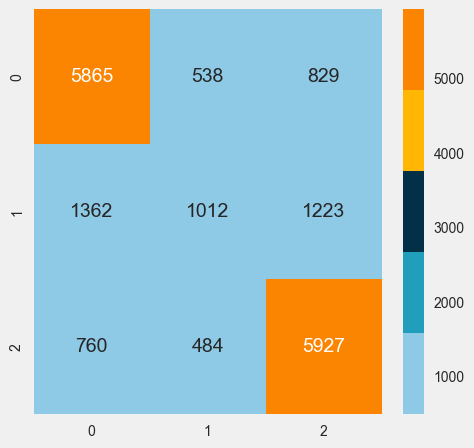

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test,predictedLogReg), annot=True, fmt="d", cmap=colors)
plt.show()

In [ ]:
cm = confusion_matrix(y_test,predictedLogReg)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[5865  538  829]
 [1362 1012 1223]
 [ 760  484 5927]]

True Positives(TP) =  5865

True Negatives(TN) =  1012

False Positives(FP) =  538

False Negatives(FN) =  1362


In [ ]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [ ]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy of LG: {0:0.4f}'.format(classification_accuracy))

Classification accuracy of LG: 0.7835


In [ ]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error of LG: {0:0.4f}'.format(classification_error))

Classification error of LG: 0.2165


In [ ]:
precision = TP / float(TP + FP)
print('Precision of LG: {0:0.4f}'.format(precision))

Precision of LG: 0.9160


In [ ]:
recall = TP / float(TP + FN)
print('Recall or Sensitivity of LG: {0:0.4f}'.format(recall))

Recall or Sensitivity of LG: 0.8115


In [ ]:
y_pred_prob = logreg.predict_proba(X_test)[0:10]
y_pred_prob

array([[7.05154391e-01, 8.98248507e-02, 2.05020758e-01],
       [8.52867547e-01, 9.58537333e-02, 5.12787201e-02],
       [8.16406076e-01, 1.02706503e-01, 8.08874213e-02],
       [7.50464452e-02, 1.48375228e-01, 7.76578327e-01],
       [3.87822969e-02, 7.47345163e-01, 2.13872540e-01],
       [5.91106132e-01, 2.32336008e-01, 1.76557860e-01],
       [1.45885008e-01, 4.28221673e-01, 4.25893318e-01],
       [9.41382119e-01, 5.18694472e-02, 6.74843396e-03],
       [2.12946600e-01, 1.47162329e-01, 6.39891071e-01],
       [2.32458560e-04, 2.91289715e-03, 9.96854644e-01]])


<li>In each row, the numbers sum to 1.</li>
<li>There are 3 columns which correspond to 3 classes - positive, negative, neutral</li>

 



   ##### Predict_proba process
   Predicts the probabilities --> Choose the class with the highest probability

In [ ]:
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Prob of - Negative (0)', 
                                                         'Prob of - Neutral (1)', 'Prob of - Positive (2)'])
y_pred_prob_df

,Prob of - Negative (0),Prob of - Neutral (1),Prob of - Positive (2)
0,0.705154,0.089825,0.205021
1,0.852868,0.095854,0.051279
2,0.816406,0.102707,0.080887
3,0.075046,0.148375,0.776578
4,0.038782,0.747345,0.213873
5,0.591106,0.232336,0.176558
6,0.145885,0.428222,0.425893
7,0.941382,0.051869,0.006748
8,0.212947,0.147162,0.639891
9,0.000232,0.002913,0.996855


### **Training the model using SVM:**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state = 42, test_size = 0.20)
print(f"Training:\n X = {X_train.shape}\n y = {y_train.shape}")
print(f"Testing:\n X = {X_test.shape}\n y = {y_test.shape}")

Training:
 X = (72000, 5000)
 y = (72000,)
Testing:
 X = (18000, 5000)
 y = (18000,)


In [ ]:
import nltk

print(nltk.data.path)


['C:\\Users\\Ajay/nltk_data', 'c:\\Users\\Ajay\\Desktop\\PROJECT\\Amazon_review_sentiment _Analysis\\venv\\nltk_data', 'c:\\Users\\Ajay\\Desktop\\PROJECT\\Amazon_review_sentiment _Analysis\\venv\\share\\nltk_data', 'c:\\Users\\Ajay\\Desktop\\PROJECT\\Amazon_review_sentiment _Analysis\\venv\\lib\\nltk_data', 'C:\\Users\\Ajay\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


In [ ]:
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)

In [ ]:
y_pred = svm.predict(X_test)
accuracy_score(y_test, y_pred)*100

70.16666666666667

In [ ]:
inp_test = input("Enter review: ")
print(inp_test)
inp_test = preprocess_text(inp_test)
print("After preprocessing: ", inp_test)
inp_test = tfidf_vectorizer.transform([inp_test])
svm.predict(inp_test)

Bad Quality Product 
After preprocessing:  bad quality product


array(['Negative'], dtype=object)

#### **Model Analysis:**

In [ ]:
# classification_report and accuracy_score using sklearn.metrics library
print("Classification Report")
print(f"{classification_report(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.72      0.81      0.76      7088
     Neutral       0.49      0.28      0.36      3697
    Positive       0.74      0.81      0.77      7215

    accuracy                           0.70     18000
   macro avg       0.65      0.63      0.63     18000
weighted avg       0.68      0.70      0.68     18000

Accuracy: 0.7016666666666667


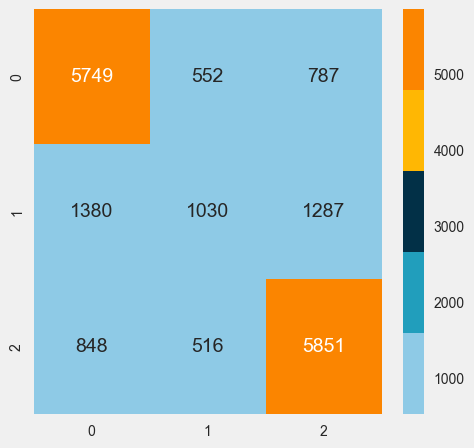

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap=colors)
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[5749  552  787]
 [1380 1030 1287]
 [ 848  516 5851]]

True Positives(TP) =  5749

True Negatives(TN) =  1030

False Positives(FP) =  552

False Negatives(FN) =  1380


In [ ]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [ ]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy of SVM: {0:0.4f}'.format(classification_accuracy))

Classification accuracy of SVM: 0.7782


In [ ]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error of SVM: {0:0.4f}'.format(classification_error))

Classification error of SVM: 0.2218


In [ ]:
precision = TP / float(TP + FP)
print('Precision of SVM: {0:0.4f}'.format(precision))

Precision of SVM: 0.9124


In [ ]:
recall = TP / float(TP + FN)
print('Recall or Sensitivity of SVM: {0:0.4f}'.format(recall))

Recall or Sensitivity of SVM: 0.8064


#### **Exporting the models as a pickled file:**

In [ ]:
import pickle

pi = {'vectorizer': tfidf_vectorizer, 'logreg': logreg, 'svm': svm, 'rf': rf}

# Save the models using pickle
pickle.dump(pi, open('models.p', 'wb'))
